# Poisson equation in 1D with Dirichlet/PointSetOperator boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
\nabla^2 u = 2, \qquad x \in [-1, 1]
$$
with the Neumann boundary condtions on the right boundary
$$
\left. \dfrac{du}{dx} \right|_{x=1} = 4
$$
and Dirichlet boundary conditions on the left boundary
$$
u(-1) = 0.
$$

The exact solution is $u(x) = (x+1)^2$

## Implementation

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-09 09:17:22.645579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 09:17:22.645630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 09:17:22.645660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 09:17:22.654210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [3]:
geom = dde.geometry.Interval(-1, 1)

In [4]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2

In [5]:
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], -1)

In [6]:
bc_l = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)

In [7]:
def true_solution(x):
    return (x+1)**2

In [8]:
def d_func(x):
    return 2*(x+1)

def dy_x(x, y, X):
    dy_x = dde.grad.jacobian(y, x)
    return dy_x

In [9]:
boundary_pts = geom.random_boundary_points(2)
boundary_pts

array([[-1.],
       [ 1.]], dtype=float32)

In [10]:
r_boundary_pts = boundary_pts[dde.utils.isclose(boundary_pts, 1)].reshape(-1, 1)
r_boundary_pts

array([[1.]], dtype=float32)

In [11]:
d_func(r_boundary_pts)

array([[4.]], dtype=float32)

In [12]:
r_boundary_pts.shape, d_func(r_boundary_pts).shape

((1, 1), (1, 1))

In [13]:
dde.icbc.PointSetOperatorBC?

Init signature: dde.icbc.PointSetOperatorBC(points, values, func)
Docstring:     
General operator boundary conditions for a set of points.

Compare the function output, func, (that associates with `points`)
    with `values` (target data).

Args:
    points: An array of points where the corresponding target values are
        known and used for training.
    values: An array of values which output of function should fulfill.
    func: A function takes arguments (`inputs`, `outputs`, `X`)
        and outputs a tensor of size `N x 1`, where `N` is the length of
        `inputs`. `inputs` and `outputs` are the network input and output
        tensors, respectively; `X` are the NumPy array of the `inputs`.
File:           ~/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/deepxde/icbc/boundary_conditions.py
Type:           type
Subclasses:     

func(`points`, `outputs`, X) == `values`

In [14]:
bc_r = dde.icbc.PointSetOperatorBC(r_boundary_pts, d_func(r_boundary_pts), dy_x)

2023-10-09 09:17:26.981935: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 09:17:26.982816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [15]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_r, bc_l],
                    num_domain=16,
                    num_boundary=2,
                    solution=true_solution,
                    num_test=100)

In [16]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [17]:
model = dde.Model(data, net)

In [18]:
def dy_x(x, y):
    dy_x = dde.grad.jacobian(y, x)
    return dy_x

def dy_xx(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx

In [19]:
dde.callbacks.OperatorPredictor?

Init signature:
dde.callbacks.OperatorPredictor(
    x,
    op,
    period=1,
    filename=None,
    precision=2,
)
Docstring:     
Generates operator values for the input samples.

Args:
    x: The input data.
    op: The operator with inputs (x, y).
    period (int): Interval (number of epochs) between checking values.
    filename (string): Output the values to the file `filename`.
        The file is kept open to allow instances to be re-used.
        If ``None``, output to the screen.
    precision (int): The precision of variables to display.
File:           ~/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/deepxde/callbacks.py
Type:           type
Subclasses:     FirstDerivative

In [20]:
first_derivative = dde.callbacks.OperatorPredictor(
    geom.random_boundary_points(2), op=dy_x, period=200, filename='first_derivative.txt'
)

second_derivative = dde.callbacks.OperatorPredictor(
    geom.random_boundary_points(2), op=dy_xx, period=200, filename='second_derivative.txt'
)

In [21]:
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.003909 s



In [22]:
loss_histroy, train_state = model.train(
    iterations=10000, callbacks=[first_derivative, second_derivative]
)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x7fefe27ebd90>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fefe27ebd90>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-10-09 09:17:28.671259: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fb6489ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 09:17:28.671309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-09 09:17:28.682402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 09:17:29.331073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-09 09:17:29.337509: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-09 09:17:29.803461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [3.98e+00, 1.23e+01, 3.47e-01]    [4.03e+00, 1.23e+01, 3.47e-01]    [8.85e-01]    
1000      [1.10e-03, 2.07e-07, 3.15e-08]    [8.78e-04, 2.07e-07, 3.15e-08]    [1.62e-03]    
2000      [2.59e-04, 7.37e-09, 9.22e-09]    [2.24e-04, 7.29e-09, 9.22e-09]    [1.16e-03]    
3000      [1.06e-04, 1.28e-11, 8.64e-10]    [9.35e-05, 1.64e-11, 8.64e-10]    [7.70e-04]    
4000      [5.02e-05, 7.59e-07, 1.91e-06]    [4.33e-05, 7.59e-07, 1.91e-06]    [4.79e-04]    
5000      [2.54e-05, 2.85e-05, 5.59e-05]    [2.00e-05, 2.85e-05, 5.59e-05]    [2.31e-03]    
6000      [1.07e-05, 1.42e-10, 1.39e-10]    [8.83e-06, 1.42e-10, 1.39e-10]    [2.45e-04]    
7000      [5.63e-06, 3.40e-06, 4.37e-06]    [4.18e-06, 3.40e-06, 4.37e-06]    [6.71e-04]    
8000      [3.28e-06, 3.09e-09, 4.80e-09]    [2.56e-06, 3.06e-09, 4.80e-09]    [7.50e-05]    
9000      [2.78e-06, 5.82e-11, 6.27e-12]    [2.28e-06, 5.82e-11, 6.27e

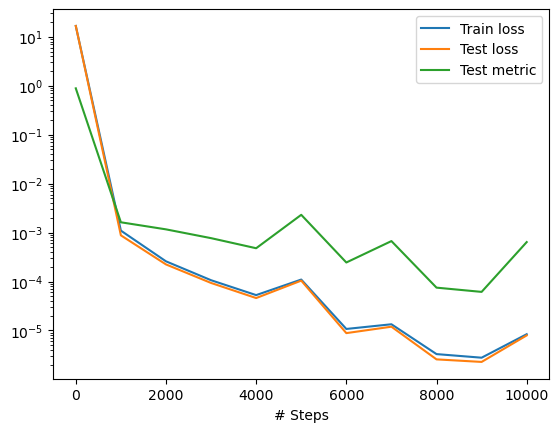

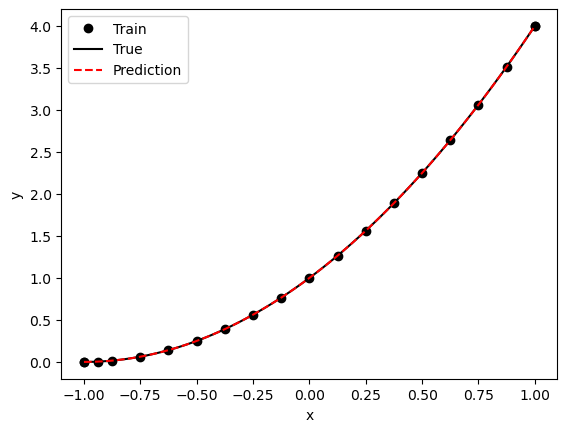

In [23]:
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)

In [24]:
import pandas as pd

In [32]:
df = pd.read_csv('first_derivative.txt', delimiter='\t', header=None)
df.iloc[::5]

,0
0,"0 [4.92e-01, 4.92e-01]"
5,"1000 [-7.00e-03, 4.00e+00]"
10,"2000 [-4.50e-03, 4.00e+00]"
15,"3000 [-3.04e-03, 4.00e+00]"
20,"4000 [-2.63e-03, 4.00e+00]"
25,"5000 [-4.43e-03, 3.99e+00]"
30,"6000 [-9.89e-04, 4.00e+00]"
35,"7000 [-1.29e-03, 4.00e+00]"
40,"8000 [-4.60e-04, 4.00e+00]"
45,"9000 [-3.31e-04, 4.00e+00]"


In [30]:
df = pd.read_csv('second_derivative.txt', delimiter='\t', header=None)
df.iloc[::5]

,0
0,"0 [2.48e-01, -2.48e-01]"
5,"1000 [1.92e+00, 1.99e+00]"
10,"2000 [1.97e+00, 1.99e+00]"
15,"3000 [1.98e+00, 1.99e+00]"
20,"4000 [1.98e+00, 2.00e+00]"
25,"5000 [1.99e+00, 2.00e+00]"
30,"6000 [1.99e+00, 2.00e+00]"
35,"7000 [1.99e+00, 2.00e+00]"
40,"8000 [2.00e+00, 2.00e+00]"
45,"9000 [2.00e+00, 2.00e+00]"


In [33]:
import os
os.remove('first_derivative.txt')
os.remove('second_derivative.txt')